# Synthetic Data Fit

In [1]:
from drdmannturb.calibration import CalibrationProblem
from drdmannturb.data_generator import OnePointSpectraDataGenerator
from drdmannturb.shared.parameters import NNParameters, ProblemParameters, LossParameters, PhysicalParameters

import torch
import torch.nn as nn
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu" 

# v2: torch.set_default_device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

L = 0.59

Gamma = 3.9
sigma = 3.4

domain = torch.logspace(-1, 2, 20)

In [2]:
pb = CalibrationProblem(
    nn_params = NNParameters(
        activations = [nn.GELU(), nn.GELU()], 
    ),
    prob_params = ProblemParameters(nepochs=5),
    loss_params = LossParameters(),
    phys_params = PhysicalParameters(
        L=L,
        Gamma=Gamma,
        sigma=sigma,
        domain=domain
    ), 
    device=device
)

/home/ai/miniconda3/envs/fracturbulence/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
parameters = pb.parameters
parameters[:3] = [
    np.log(L),
    np.log(Gamma),
    np.log(sigma)
]

pb.parameters = parameters[:len(pb.parameters)]

k1_data_pts = domain
DataPoints = [(k1, 1) for k1 in k1_data_pts]

In [5]:
Data = OnePointSpectraDataGenerator(data_points=DataPoints).Data

In [6]:
pb.eval(k1_data_pts)
pb.calibrate(data=Data)


Calibrating MannNet...
torch.Size([80])
Initial loss:  0.12276974566729155

[Calibration.py -- calibrate]-> Epoch 0

loss  =  0.12276974566729155
loss  =  0.0786841519961054
loss  =  0.07092805111384747
loss  =  0.06466940327792436
loss  =  0.05959838786939223
loss  =  0.05548965290734296
loss  =  0.052160461551530146
loss  =  0.04946277367569862
loss  =  0.047276597197388893
loss  =  0.04550473376199244
loss  =  0.044068431088205025
loss  =  0.0429039245381057
loss  =  0.041959634750667774
loss  =  0.03795044990485308
loss  =  0.037949399452501115
loss  =  0.03794023202191943
loss  =  0.0378769318833956
loss  =  0.03786673520025674
loss  =  0.03782454327765501
loss  =  0.037776616643019845
loss  =  0.03759537092587728
loss  =  0.037520698254529576
loss  =  0.037039508188324306
loss  =  0.036958542105646745
loss  =  0.036365445891828024
---------------------------------



[Calibration.py -- calibrate]-> Epoch 1



/home/ai/miniconda3/envs/fracturbulence/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


loss  =  0.036365445891828024
loss  =  0.036097857684428
loss  =  0.035835140855498354
loss  =  0.034894766744195525
loss  =  0.034742501337233396
loss  =  0.03411947686825911
loss  =  0.033733517847698215
loss  =  0.031971902792658734
loss  =  0.03173354978679639
loss  =  0.03055350066951389
loss  =  0.02589429822762146
loss  =  0.023291974953476548
loss  =  0.02187158514500579
loss  =  0.02119079770096552
loss  =  0.020632291809004916
loss  =  0.020347806397925234
loss  =  0.019956692193009485
loss  =  0.01973556206601884
loss  =  0.019370202090000732
loss  =  0.019087669954195488
loss  =  0.01799836520124859
loss  =  0.017883099266274915
loss  =  0.017801896539928638
loss  =  0.01727839605436274
loss  =  0.017156690162351912
---------------------------------



[Calibration.py -- calibrate]-> Epoch 2

loss  =  0.017156690162351912
loss  =  0.016960508647228378
loss  =  0.016098503223844714
loss  =  0.015932498545729545
loss  =  0.015194383660177536
loss  =  0.01506999155494172
loss 

array([-4.64273615e-01,  7.13704810e-01,  9.88413945e-01,  1.36281208e+00,
       -6.46786957e-01, -3.52467618e-02,  7.78901961e-01, -7.74610195e-02,
       -3.01774050e-01, -3.46292599e-01, -8.80342129e-02,  4.81140990e-01,
        3.80268198e-01,  1.20311208e-01, -5.32929302e-01, -3.85682488e-01,
       -3.68494910e-01,  6.02577861e-01,  4.53825642e-01,  5.78460609e-01,
        9.36066730e-02,  5.48811708e-01, -4.19299919e-01,  4.56010491e-01,
        1.63881339e-01, -1.67745469e-01,  6.12507762e-01,  1.91935953e-01,
        6.54801121e-01, -8.84902012e-01, -1.70807139e-01, -6.00400421e-02,
       -5.62885401e-01,  1.14385189e+00,  1.61259262e-01, -5.65454595e-02,
        1.86748872e-01, -1.23721116e-01,  2.98532723e-01,  6.29635940e-01,
        2.43731852e-01, -3.93542862e-01, -1.91615126e-02, -3.71981763e-01,
       -2.89670939e-01, -1.17633434e-01, -1.66222896e-01, -1.63771895e-01,
       -5.97512634e-01, -2.69044109e-01, -2.84838636e-01, -7.93785387e-02,
        2.67914636e-02,  

k1.size: torch.Size([20])   self.kF_data_vals: torch.Size([80])


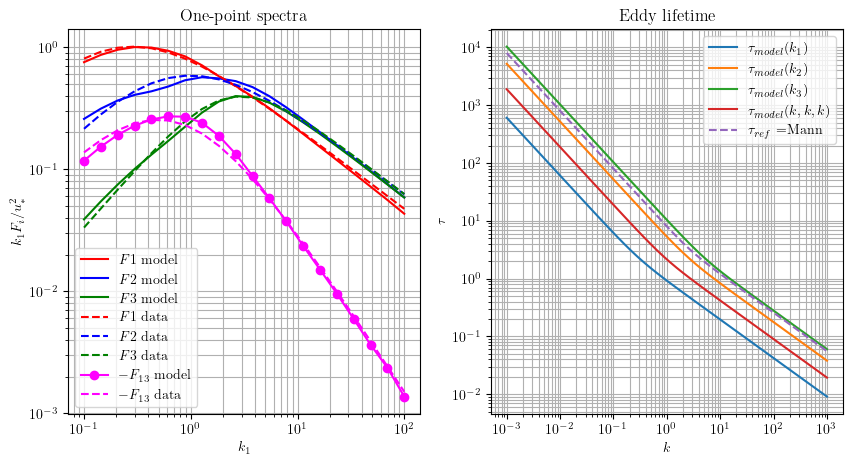

In [7]:
pb.plot(plt_dynamic=False)

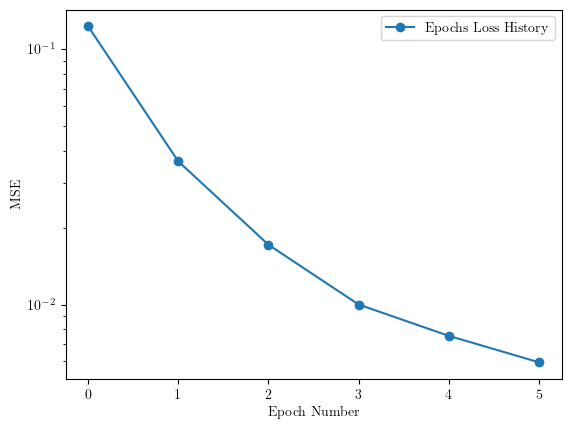

In [8]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot( pb.loss_history_epochs, 'o-', label="Epochs Loss History")
plt.legend()
plt.xlabel("Epoch Number")
plt.ylabel("MSE")
plt.yscale('log')

plt.show()
